<a href="https://colab.research.google.com/github/OksanaGlazkova/Python/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_Data_Engineer_Python_SKYTEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import random
import datetime
import multiprocessing
from multiprocessing import Pool, cpu_count
import csv
from collections import OrderedDict
import matplotlib.pyplot as plt
import scipy.stats as stats

In [ ]:
def generate_random_datetime(start_datetime, end_datetime):
    time_between_dates = end_datetime - start_datetime
    between_dates = time_between_dates.total_seconds()
    random_number_of_seconds = random.randrange(int(between_dates))
    random_datetime = start_datetime + datetime.timedelta(seconds=random_number_of_seconds)
    return random_datetime

In [ ]:
num_records = 10000000

In [ ]:
data = {
    'gender': [random.choice(['male', 'female']) for _ in range(10000000)],
    'weight': [],
    'date_of_birth': []
}

for i in range(10000000):
    gender = data['gender'][i]
    data['weight'].append(round(random.uniform(40.0, 120.0), 1))

    start_date = datetime.datetime(1963, 1, 1)
    end_date = datetime.datetime(2005, 12, 31)
    date_of_birth = generate_random_datetime(start_date, end_date)
    data['date_of_birth'].append(date_of_birth)

    if random.random() < 0.05:
        data['weight'][i] = pd.NA
    if random.random() < 0.02:
        data['date_of_birth'][i] = pd.NA

In [ ]:
df = pd.DataFrame(data)
df.head(10)

,gender,weight,date_of_birth
0,female,<NA>,1972-06-12 18:03:47
1,female,80.3,1999-07-22 05:55:15
2,male,91.0,1991-08-11 20:02:16
3,female,106.8,1974-03-09 20:14:11
4,female,<NA>,1963-04-04 04:02:30
5,male,118.1,1992-06-08 20:49:21
6,male,59.1,<NA>
7,female,94.7,1982-06-28 06:33:32
8,female,119.4,2003-08-24 11:07:59
9,male,44.3,1966-07-10 13:13:23


Добавим 10% копий

In [ ]:
df_copy = df.iloc[:100].copy()

In [ ]:
df = pd.concat([df, df_copy], ignore_index=True)

In [ ]:
num_rows = df.shape[0]
print(num_rows)

10000100


In [ ]:
df.to_csv('dataset_for_test.csv', index=False)

#Считывание и процессинг

Удалим дубликаты на уровне csv файла.

In [ ]:
def read_unique_rows(filename):
    unique_rows = OrderedDict()
    with open(filename, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            unique_rows[tuple(row.values())] = row
    return list(unique_rows.values())

In [ ]:
unique_data = read_unique_rows('dataset_for_test.csv')

Строки в которых нет цифр превращаем в пустые

In [ ]:
df_unique_data = pd.DataFrame(unique_data)

In [ ]:
df_unique_data[df_unique_data['weight'].isin([None, np.nan, ''])].head(5)


,gender,weight,date_of_birth
0,female,,1972-06-12 18:03:47
4,female,,1963-04-04 04:02:30
10,female,,1985-04-16 16:20:07
27,male,,1965-07-06 17:42:53
44,male,,1985-09-24 09:03:51


In [ ]:
df_unique_data = df_unique_data[df_unique_data['weight'].apply(lambda x: any(char.isdigit() for char in str(x)))]

In [ ]:
df_unique_data = df_unique_data.dropna(subset=['weight'])

In [ ]:
df_unique_data[df_unique_data['weight'].isin([None, np.nan, ''])].head(5)

,gender,weight,date_of_birth


In [ ]:
df_unique_data[~df_unique_data['weight'].str.contains(r'\d')].head(5)

,gender,weight,date_of_birth


Удаляет пустые строки и строки с 'NA'

In [ ]:
df_unique_data[df_unique_data['date_of_birth'].isin([None, np.nan, ''])].head(5)

,gender,weight,date_of_birth
6,male,59.1,
23,male,44.4,
94,male,102.6,
185,male,107.3,
194,male,50.8,


In [ ]:
df_unique_data.replace('', np.nan, inplace=True)

In [ ]:
df_unique_data.dropna(inplace=True)

In [ ]:
df_unique_data[df_unique_data['date_of_birth'].isin([None, np.nan, ''])].head(5)

,gender,weight,date_of_birth


удалим записи в промежутке от 1 до 3 часов ночи

In [ ]:
df_unique_data['date_of_birth'] = pd.to_datetime(df_unique_data['date_of_birth'])

In [ ]:
df_unique_data[(df_unique_data['date_of_birth'].dt.hour == 3)].head(5)

,gender,weight,date_of_birth
30,male,53.8,1977-02-21 03:24:20
64,female,85.8,1993-06-21 03:42:42
65,male,84.0,1967-07-03 03:37:26
115,male,49.7,1990-11-20 03:33:30
119,female,109.7,1976-03-30 03:28:46


In [ ]:
result = df_unique_data[(df_unique_data['date_of_birth'].dt.hour < 1) | (df_unique_data['date_of_birth'].dt.hour > 3)]

In [ ]:
result[(result['date_of_birth'].dt.hour == 3)].head(5)

,gender,weight,date_of_birth


#Расчет метрик

In [ ]:
result.loc[:, 'weight'] = pd.to_numeric(result['weight'], errors='coerce')

In [ ]:
metrics = result.groupby(result['date_of_birth'].dt.hour).agg(
    unique_strings=('gender', 'nunique'),
    mean_weight=('weight', 'mean'),
    median_weight=('weight', 'median')
)

In [ ]:
metrics.head(15)

,unique_strings,mean_weight,median_weight
date_of_birth,,,
0,2,80.042205,80.1
4,2,79.982397,80.0
5,2,79.978984,79.9
6,2,79.988116,80.0
7,2,79.999269,80.0
8,2,80.025555,80.0
9,2,79.996297,80.0
10,2,79.971989,80.0
11,2,79.989248,80.0


**SQL запрос для аналогичной агрегации (на примере бд Postgresql)**

SELECT
  hour_group,
  COUNT(DISTINCT gender) AS unique_genders,
  AVG(weight) AS average_weight,
  PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY weight) AS median_weight
FROM (
  SELECT
    to_char(date_of_birth, 'HH24') AS hour_group,
    gender,
    weight
  FROM your_table
) AS grouped_data
GROUP BY hour_group
ORDER BY hour_group

#Мерж с метриками

In [ ]:
result['hour_of_birth'] = result['date_of_birth'].dt.hour

<ipython-input-29-0d9ce76167f5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['hour_of_birth'] = result['date_of_birth'].dt.hour


In [ ]:
result = result.merge(
    metrics,
    left_on='hour_of_birth',
    right_index=True,
    suffixes=('_original', '_metrics')
)

In [ ]:
result.head(10)

,gender,weight,date_of_birth,hour_of_birth,unique_strings,mean_weight,median_weight
1,female,80.3,1999-07-22 05:55:15,5,2,79.978984,79.9
36,female,106.2,1995-01-04 05:07:23,5,2,79.978984,79.9
41,male,94.7,1963-05-28 05:57:20,5,2,79.978984,79.9
67,male,62.5,2000-09-14 05:31:50,5,2,79.978984,79.9
89,female,54.0,1969-06-22 05:14:13,5,2,79.978984,79.9
111,female,92.0,1968-09-20 05:05:27,5,2,79.978984,79.9
134,female,78.5,1987-05-05 05:50:58,5,2,79.978984,79.9
145,female,53.5,1994-03-01 05:52:31,5,2,79.978984,79.9
192,female,114.6,1967-01-02 05:35:36,5,2,79.978984,79.9
198,male,118.8,1984-03-10 05:47:54,5,2,79.978984,79.9


#Аналитические метрики

**Гистограмма**

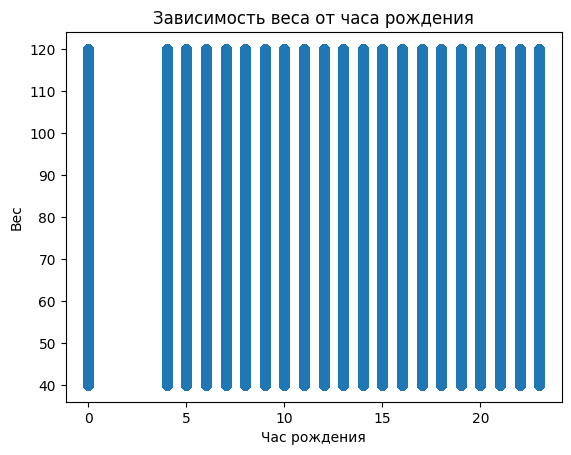

In [ ]:
plt.scatter(result['hour_of_birth'], result['weight'])
plt.xlabel('Час рождения')
plt.ylabel('Вес')
plt.title('Зависимость веса от часа рождения')
plt.show()

**95% доверительный интервал
Используем t-распределение, так как размер выборки мал (n < 30)**

In [ ]:
confidence_level = 0.95
mean = result['weight'].mean()
std = result['weight'].std()
n = len(result)
t_critical = stats.t.ppf((1 + confidence_level) / 2, n - 1)
margin_of_error = t_critical * std / (n * 0.5)
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

In [ ]:
print(f'95% доверительный интервал для веса: {confidence_interval}')

95% доверительный интервал для веса: (80.00686016197965, 80.00688239026512)


#Визуализация

**график среднего значения numeric колонки (y) по месяцам (x)**

In [ ]:
result['month_of_birth'] = result['date_of_birth'].dt.month

In [ ]:
grouped_by_month = result.groupby('month_of_birth')['weight'].mean()

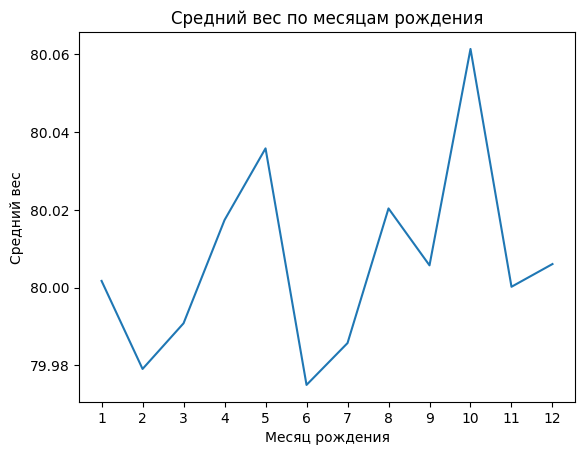

In [ ]:
plt.plot(grouped_by_month.index, grouped_by_month.values)
plt.xlabel('Месяц рождения')
plt.ylabel('Средний вес')
plt.title('Средний вес по месяцам рождения')
plt.xticks(range(1, 13))
plt.show()

Heatmap по частотности символов в колонке string

In [ ]:
import seaborn as sns
from collections import Counter

In [ ]:
symbol_counts = Counter(result['gender'])

In [ ]:
df_symbol_counts = pd.DataFrame.from_dict(symbol_counts, orient='index', columns=['Частота'])

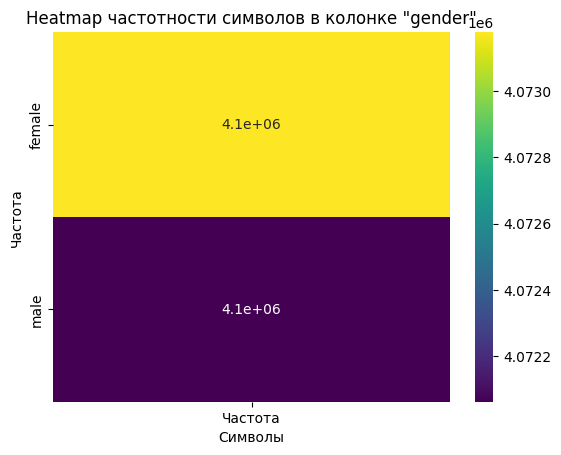

In [ ]:
sns.heatmap(df_symbol_counts, annot=True, cmap='viridis')
plt.xlabel('Символы')
plt.ylabel('Частота')
plt.title('Heatmap частотности символов в колонке "gender"')
plt.show()

#Доп. задание 1

In [ ]:
np.random.seed(42)
result_shuffled = result.sample(frac=1)
result_part1 = result_shuffled.iloc[:1]
result_part2 = result_shuffled.iloc[1:2]
result_part3 = result_shuffled.iloc[2:]

Проверка на статистическую значимость различий

In [ ]:
f_statistic, p_value = stats.f_oneway(result_part1['weight'], result_part2['weight'], result_part3['weight'])
print(f"F-statistic: {f_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

F-statistic: 0.0904
P-value: 0.9136


Оценка силы эффекта

In [ ]:
total_variance = result['weight'].var(ddof=1)
effect_size = f_statistic / (f_statistic + (len(df) - 3))
print(f"Эффект размера (η²): {effect_size:.4f}")

Эффект размера (η²): 0.0000
